###-------------------------------(A)--------------------------------------

Replicating the two graphs created in Section 2 and 3 for the column 'Deaths'. Picking N = 20 countries and starting Day 0 at K = 10 deaths.

In [1]:
#Installing the adjustText library
!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-cp36-none-any.whl size=7099 sha256=da69cf0f7944cfec27029fa74d7376da1bf3ddf2bcc7c44baa354113b36fcee1
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


In [2]:
# Data from here:
# https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from adjustText import adjust_text
from matplotlib.ticker import ScalarFormatter

# READ CUMULATIVE TABLE
covid_cumulative = pd.read_excel("covid_a_master_cumulative_table.xlsx")

## FILTER THE LAST DAY OF THE RESULTS AND PICK THE TOP N IN # OF DEATHS

In [3]:
# This part is necessary instead of simply ['Date'].max() because some countries do not report on certain days (e.g. Spain on Sundays) -- FIXED BUG
last_day_per_country = covid_cumulative.groupby(by=['Countries'])['Date'].max() # type(last_day_per_country) is pandas.Series
last_day_per_country = last_day_per_country.to_frame() # We convert it to pandas.DataFrame
last_day_per_country.reset_index(inplace=True) # And reset the index so that we can further join on 'Countries'

In [4]:
# N: HOW MANY TOP COUNTRIES YOU WANT TO PICK IN TERMS OF # OF DEATHS
N = 20
last_day = pd.merge(covid_cumulative, last_day_per_country, how='inner', left_on = ['Countries', 'Date'], right_on = ['Countries', 'Date'])
last_day = last_day.sort_values('Deaths', ascending=False)
top_countries = last_day[:N]['Countries'].tolist()

## FURTHER FILTER THE TOP N COUNTRIES WITH >K DEATHS


In [5]:
# K: HOW MANY DEATHS YOU CONSIDER THE DAY 0
#Considering 10 deaths to be day 0 as per the instructions
K = 10
covid_top_countries = covid_cumulative[covid_cumulative.Countries.isin(top_countries)]
covid_top_countries = covid_top_countries[covid_top_countries['Deaths'] > K]

In [6]:
# FIND THE DATE THAT THE FIRST K DEATHS WERE IDENTIFIED
day_0_for_every_country = covid_top_countries.groupby(by=['Countries']).min()
day_0_for_every_country = day_0_for_every_country['Date']

In [7]:
# MERGE THE TWO TO GET THE DAY_0 IN THE df, AND CALCULATE THE DAYS_FROM_0
covid_top_countries = covid_top_countries.merge(day_0_for_every_country, how='inner', on='Countries')
covid_top_countries.rename(columns = {'Date_y': 'Day_0'}, inplace = True)
covid_top_countries['Days_from_0'] = (covid_top_countries['Date_x'] - covid_top_countries['Day_0']).dt.days

### CREATE THE MAX_DEATHS DF TO USE IT IN LABELING THE GRAPHS

In [8]:
max_deaths = covid_top_countries.groupby(by=['Countries']).max()
max_deaths['Case_fatality_rate'] = max_deaths['Deaths']/max_deaths['Cases']*100
max_deaths.sort_values('Deaths', ascending=False)
max_deaths['Infection_rate_per_1m'] = max_deaths['Cases']/max_deaths['Population']*1000000
max_deaths['Mortality_rate_per_1m'] = max_deaths['Deaths']/max_deaths['Population']*1000000
max_deaths.drop('Unnamed: 0', axis = 1, inplace = True)
max_deaths.to_excel('covid_b_max_deaths.xlsx')

### Create the data to plot the dashed lines of doubling slopes: 1, 2, 3, 7 days. Formula for doubling: \\(K*2^{(days)}\\)

In [9]:
# FUNCTION THAT GIVES YOU THE DOUBLING SLOPE OF 1, 2, 3, 7 DAYS
x1 = np.array([0, 15])
x2 = np.array([0, 30])
x3 = np.array([0, 45])
x7 = np.array([0, 105])

y_1 = np.array([K, K*2**(x1[1])])
y_2 = np.array([K, K*2**(x2[1]/2)])
y_3 = np.array([K, K*2**(x3[1]/3)])
y_7 = np.array([K, K*2**(x7[1]/7)])

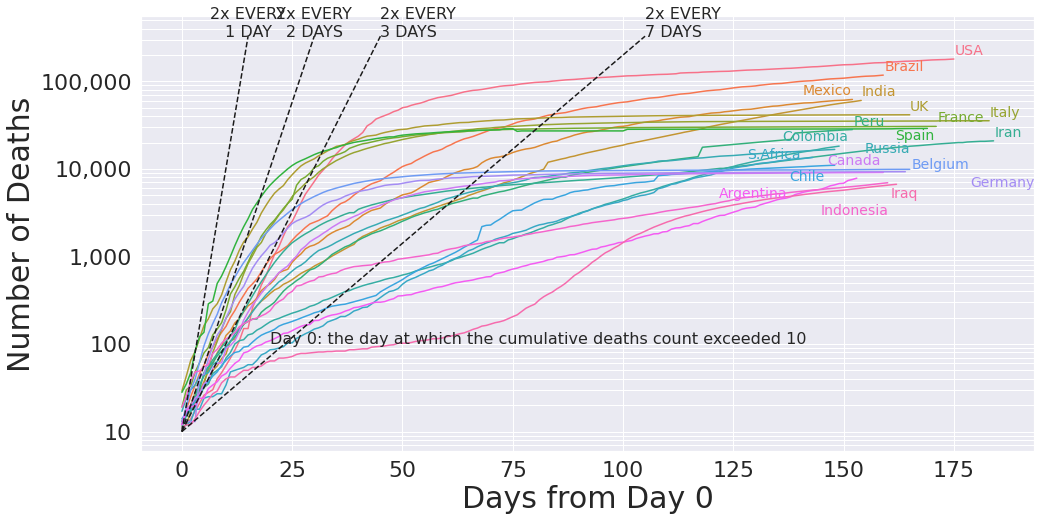

In [11]:
#Analysis for deaths (Recreating 
sns.set(rc={'figure.figsize':(16,8)}, font_scale = 2)
style = dict(size=10, color='gray')

ax = sns.lineplot(x="Days_from_0", y="Deaths", hue="Countries", data=covid_top_countries, markers=True, hue_order=top_countries, legend=False)
ax.set_yscale('log')
plt.grid(True, which='both')
ax.plot(x1, y_1, 'k--')
ax.plot(x2, y_2, 'k--')
ax.plot(x3, y_3, 'k--')
ax.plot(x7, y_7, 'k--')
ax.set_xlabel("Days from Day 0",fontsize=30)
ax.set_ylabel("Number of Deaths",fontsize=30)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
# plt.xlim([0, 150])
plt.text(20, 100, 'Day 0: the day at which the cumulative deaths count exceeded {:.0f}'.format(K), fontsize=16)
plt.text(x1.max(), y_1.max(), '2x EVERY\n1 DAY', ha = 'center', fontsize=16)
plt.text(x2.max(), y_2.max(), '2x EVERY\n2 DAYS', ha = 'center', fontsize=16)
plt.text(x3.max(), y_3.max(), '2x EVERY\n3 DAYS', ha = 'left', fontsize=16)
plt.text(x7.max(), y_7.max(), '2x EVERY\n7 DAYS', ha = 'left', fontsize=16)
texts = [plt.text(max_deaths.loc[str(country)]['Days_from_0'], max_deaths.loc[str(country)]['Deaths'], str(country), fontsize=14, color=ax.get_lines()[top_countries.index(country)].get_c(), ha = 'center', va = 'center') for country in top_countries]
adjust_text(texts)

plt.savefig('Fig_1_1_Choudhary_Shreyas.png')

In [12]:
# Average_infection_rate_per_1m = max_cases['Cases'].sum()/max_cases['Population'].sum()*1000000
# print("The average infection rate is: {:.1f} per 1m people".format(Average_infection_rate_per_1m))
Average_death_rate_per_1m = max_deaths['Deaths'].sum()/max_deaths['Population'].sum()*1000000
print("The average death rate is: {:.1f} per 1m people".format(Average_death_rate_per_1m))
Average_mortality_per_cent_infected = max_deaths['Deaths'].sum()/max_deaths['Cases'].sum()*100
print("The average mortality rate is: {:.1f} per 100 people infected".format(Average_mortality_per_cent_infected))

The average death rate is: 226.8 per 1m people
The average mortality rate is: 3.7 per 100 people infected


## CALCULATE THE RATE OF CHANGE

In [13]:
# back_calc IS THE BACK WINDOW THAT IS USED TO CALCULATE THE SLOPE
back_calc = 7
slope_df = pd.DataFrame(columns=['Countries', 'Days_from_0', 'Slope', 'R2', 'P_value'])

for country in top_countries:
    one_country_data = covid_top_countries[covid_top_countries['Countries'] == str(country)].reset_index(drop=True)
#     one_country_data['log_cases'] = np.log10(one_country_data['Cases'])
    for i in np.arange(back_calc, len(one_country_data)+1):
        x = one_country_data.loc[i-back_calc: i, 'Days_from_0'] # That is the 'Days_from_0'
        y = one_country_data.loc[i-back_calc: i, 'Deaths'] # 
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        one_country_data.loc[i-1, 'Slope'] = slope
        one_country_data.loc[i-1, 'R2'] = r_value * r_value
        one_country_data.loc[i-1, 'P_value'] = p_value
        one_country = one_country_data[['Countries', 'Days_from_0', 'Slope', 'R2', 'P_value']]
    
    slope_df = slope_df.append(one_country, ignore_index=False)
    
slope_df.head(15)

,Countries,Days_from_0,Slope,R2,P_value
0,USA,0,NaN,NaN,NaN
1,USA,1,NaN,NaN,NaN
2,USA,2,NaN,NaN,NaN
3,USA,3,NaN,NaN,NaN
4,USA,4,NaN,NaN,NaN
5,USA,5,NaN,NaN,NaN
6,USA,6,3.011905,0.974751,0.000005
7,USA,7,3.738095,0.958956,0.000022
8,USA,8,4.464286,0.952415,0.000034
9,USA,9,5.404762,0.941221,0.000065


In [14]:
slope_df.set_index('Countries', drop=False, inplace=True)
slope_df.to_excel('covid_c_slope_daily_deaths.xlsx')

In [15]:
slope_df.index.name = None
max_slope = slope_df.groupby(by=['Countries']).max()
max_slope = max_slope.sort_values('Slope', ascending=False)
max_slope['Countries'] = max_slope.index

data_1_5 = slope_df[slope_df.Countries.isin(max_slope[:5]['Countries'].tolist())]
countries_1_5 = max_slope[:5]['Countries'].tolist()
data_6_10 = slope_df[slope_df.Countries.isin(max_slope[5:10]['Countries'].tolist())]
countries_6_10 = max_slope[5:10]['Countries'].tolist()
data_11_15 = slope_df[slope_df.Countries.isin(max_slope[10:15]['Countries'].tolist())]
countries_11_15 = max_slope[10:15]['Countries'].tolist()
data_16_20 = slope_df[slope_df.Countries.isin(max_slope[15:20]['Countries'].tolist())]
countries_16_20 = max_slope[15:20]['Countries'].tolist()
max_slope

,Days_from_0,Slope,R2,P_value,Countries
Countries,,,,,
USA,175,2876.345238,0.998196,0.001091,USA
Brazil,159,1152.630952,0.997301,0.000060,Brazil
France,171,1010.666667,0.998144,0.019353,France
UK,165,977.142857,0.996646,0.000400,UK
India,154,971.190476,0.999857,0.000778,India
Peru,152,922.119048,0.999988,0.030433,Peru
Spain,169,872.214286,0.999424,1.000000,Spain
Italy,183,821.571429,0.999744,0.045427,Italy
Mexico,152,802.785714,0.996012,0.000237,Mexico


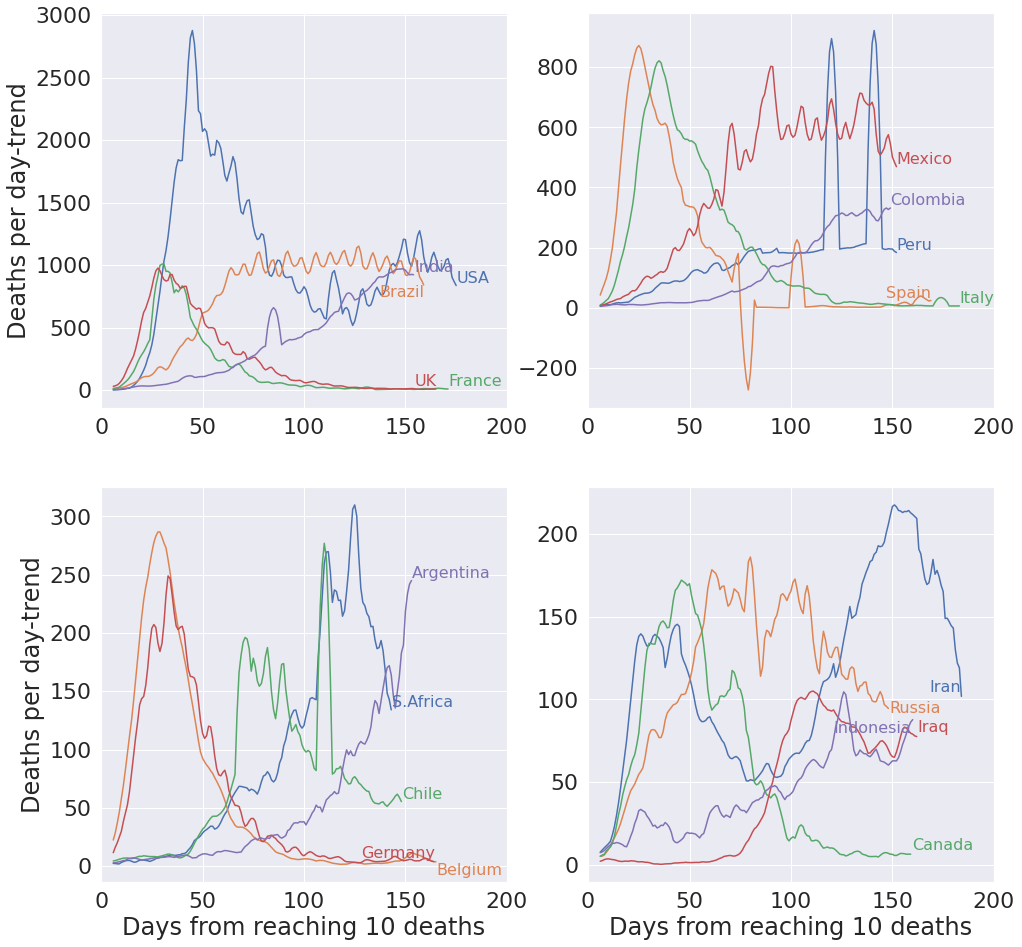

In [17]:
sns.set(rc={'figure.figsize':(16,16)}, font_scale = 2)
fig, axes = plt.subplots(2, 2)

sns.lineplot(x="Days_from_0", y="Slope", hue="Countries", data=data_1_5, markers=True, hue_order=countries_1_5, legend=False, ax=axes[0, 0])
texts = [axes[0, 0].text(max_deaths.loc[str(country)]['Days_from_0'], slope_df.loc[str(country)]['Slope'].iloc[-1], str(country), fontsize=16, color=axes[0, 0].get_lines()[countries_1_5.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_1_5]
adjust_text(texts)
axes[0, 0].set_ylabel("Deaths per day-trend",fontsize=24)

sns.lineplot(x="Days_from_0", y="Slope", hue="Countries", data=data_6_10, markers=True, hue_order=countries_6_10, legend=False, ax=axes[0, 1])
texts = [axes[0, 1].text(max_deaths.loc[str(country)]['Days_from_0'], slope_df.loc[str(country)]['Slope'].iloc[-1], str(country), fontsize=16, color=axes[0, 1].get_lines()[countries_6_10.index(country)].get_c(), ha = 'left', va = 'top') for country in countries_6_10]
adjust_text(texts)

sns.lineplot(x="Days_from_0", y="Slope", hue="Countries", data=data_11_15, markers=True, hue_order=countries_11_15, legend=False, ax=axes[1, 0])
texts = [axes[1, 0].text(max_deaths.loc[str(country)]['Days_from_0'], slope_df.loc[str(country)]['Slope'].iloc[-1], str(country), fontsize=16, color=axes[1, 0].get_lines()[countries_11_15.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_11_15]
adjust_text(texts)
axes[1, 0].set_ylabel("Deaths per day-trend",fontsize=24)
axes[1, 0].set_xlabel("Days from reaching 10 deaths",fontsize=24)

sns.lineplot(x="Days_from_0", y="Slope", hue="Countries", data=data_16_20, markers=True, hue_order=countries_16_20, legend=False, ax=axes[1, 1])
texts = [axes[1, 1].text(max_deaths.loc[str(country)]['Days_from_0'], slope_df.loc[str(country)]['Slope'].iloc[-1], str(country), fontsize=16, color=axes[1, 1].get_lines()[countries_16_20.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_16_20]
adjust_text(texts)
axes[1, 1].set_xlabel("Days from reaching 10 deaths",fontsize=24)

axes[0, 1].set_ylabel("",fontsize=24)
axes[1, 1].set_ylabel("",fontsize=24)
axes[0, 0].set_xlabel("",fontsize=24)
axes[0, 1].set_xlabel("",fontsize=24)
axes[0, 1].set_xlim([0, 200])
axes[1, 1].set_xlim([0, 200])
axes[0, 0].set_xlim([0, 200])
axes[1, 0].set_xlim([0, 200])
# axes[0, 0].set_yscale('log')
# axes[0, 1].set_yscale('log')
# axes[1, 0].set_yscale('log')
# axes[1, 1].set_yscale('log')

plt.savefig('Fig_1_2_Choudhary_Shreyas.png')

###---------------------------(B)-----------------------------------

In [18]:
#Import the death rate data from the World Bank
death_rate = pd.read_excel('Death_rate_crude_per_1000_people.xls',
                           sheet_name = 'Data',
                           header = 3,
                           index_col = 0)
                    
death_rate = death_rate.ffill(axis=1).iloc[:,-1]
death_rate = death_rate.to_frame(name = "Death_rate_per_1000")
death_rate['Countries'] = death_rate.index
death_rate.replace('United States', 'USA',inplace=True)
death_rate.replace('United Kingdom', 'UK',inplace=True)
death_rate.replace('Korea, Rep.', 'S.Korea',inplace=True)
death_rate.replace('Iran, Islamic Rep.', 'Iran',inplace=True)
death_rate.replace('Saudi Arabia', 'S.Arabia',inplace=True)
death_rate.replace('South Africa', 'S.Africa',inplace=True)

In [19]:
#Left joining the dataframe with main dataframe of covid_top_countries
covid_top_countries = covid_top_countries.merge(death_rate, how='left', on='Countries')

In [23]:
#Applying the formulas given in the handout
#Applying to max_deaths dataframe for naming convention of the countries
max_deaths = covid_top_countries.groupby(by=['Countries']).max()
max_deaths['Typical_deaths_per_day'] = max_deaths['Death_rate_per_1000']*max_deaths['Population']/ 1000 /365
max_deaths['Typical_cumulative_deaths'] = (max_deaths['Days_from_0'] + 1)*max_deaths['Typical_deaths_per_day']
max_deaths['Excess_death_rate'] = max_deaths['Deaths'] /max_deaths['Typical_cumulative_deaths']*100 

In [20]:
#Applying the formulas given in the handout
#Applying to covid_top_countries dataframe for using the data in plotting the graph
covid_top_countries['Typical_deaths_per_day'] = covid_top_countries['Death_rate_per_1000']*covid_top_countries['Population']/ 1000 /365
covid_top_countries['Typical_cumulative_deaths'] = (covid_top_countries['Days_from_0'] + 1)*covid_top_countries['Typical_deaths_per_day']
covid_top_countries['Excess_death_rate'] = covid_top_countries['Deaths'] /covid_top_countries['Typical_cumulative_deaths']*100 

In [21]:
#Converting Excess_death_rate from its original object datatype to float datatype
covid_top_countries['Excess_death_rate'] = covid_top_countries['Excess_death_rate'].astype(float)

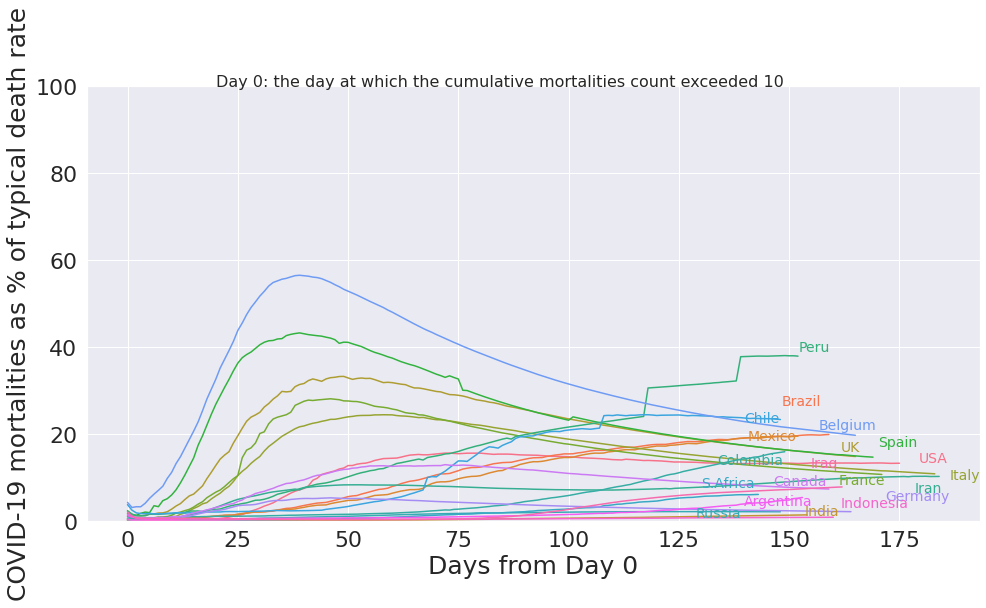

In [24]:
#Plotting fo task 1 part b
sns.set(rc={'figure.figsize':(16,8)}, font_scale = 2)
style = dict(size=10, color='gray')
ax = sns.lineplot(x="Days_from_0", y="Excess_death_rate", hue="Countries", data=covid_top_countries, markers=True, hue_order=top_countries, legend=False)
ax.set_yscale('linear')
plt.grid(True, which='both')
ax.set_xlabel("Days from Day 0",fontsize=25)
ax.set_ylabel("COVID-19 mortalities as % of typical death rate",fontsize=25)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
# plt.xlim([0, 150])
plt.ylim([0, 100])
plt.text(20, 100, 'Day 0: the day at which the cumulative mortalities count exceeded {:.0f}'.format(K), fontsize=16)
texts = [plt.text(max_deaths.loc[str(country)]['Days_from_0'],max_deaths.loc[str(country)]['Excess_death_rate'], str(country), fontsize=14, color=ax.get_lines()[top_countries.index(country)].get_c(), ha = 'center', va = 'center') for country in top_countries]
adjust_text(texts)

plt.savefig('Fig_1_3_Choudhary_Shreyas.png')